## Replication and Extension of Paper:

Dobs, Katharina & Yuan, Joanne & Martinez, Julio & Kanwisher, Nancy. (2022). Using deep convolutional neural networks to test why human face recognition works the way it does. 10.1101/2022.11.23.517478. 


In [67]:
import os
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import correlation
import torch
from torchvision import transforms
from PIL import Image
from scipy.stats import spearmanr
import numpy as np
from facenet_pytorch import InceptionResnetV1, MTCNN
from scipy.stats import pearsonr
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16
from tqdm.notebook import tqdm
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform

In [2]:
# Defining functions for preprocessing images

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [3]:
def load_model(name,num_classes):
    
    model = models.vgg16()
    
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the classifier layer to match the number of classes in your problem
    
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    
    # model.load_state_dict(torch.load('../models/'+name+'.pth')) #if you wish to load model from GPU
    model.load_state_dict(torch.load('../models/'+name+'.pth', map_location=torch.device('cpu'))) #if you wish to load model from CPU
    
    model.eval()
    
    return model

In [5]:
#Declaring the pretrained models used:

FACE_ID_CNN = InceptionResnetV1(pretrained='vggface2').eval()
UNTRAINED = models.vgg16(pretrained=False)
OBJ_CLASSIFICATION = models.vgg16(pretrained=True)
# FACE_FEATURE_EXTRACTION = MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True)


In [69]:
FACE_ID_INVERTED_CNN = load_model('Face_ID_Inverted_CNN', 101)
CARS_CNN = load_model('Cars_CNN',43)
OBJ_FACE_CNN = load_model('Obj_Face_Classification')
# FACE_ID_ASIAN_CNN = load_model('Asian_Face_ID_CNN',107)
# FACE_ID_WHITE_CNN = load_model('White_Face_ID_CNN', 115)
FACE_ID_CNN_2 = load_model('Face_ID_CNN_2', 101)


In [8]:

def target_matching_vgg16(model, stimuli_path, start_num,end_num):
    image_folder = stimuli_path
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]
    images = []
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    model.classifier[4].register_forward_hook(get_activation('classifier'))
    for image_path in image_paths:
        img = Image.open(image_path)
        # Preprocess images
        image = preprocess(img)
        # Add batch dimension
        img_tensor = image.unsqueeze(0)
        # Get penultimate layer activations
        output = model(img_tensor)
        penultimate_layer_activation = activations['classifier'][0].numpy()
        
        images.append(penultimate_layer_activation)
    
    #Getting Accuracy Scores by comparing two images to a target image

    total = 0
    correct= 0

    for i in range (start_num,int(end_num),5):
        r1 = np.random.randint(0,5)
        r2 = np.random.randint(0,5)
        while r2==r1:
            r2 = np.random.randint(0,5)
        for j in range (start_num,int(end_num),5):
            if(i!=j):
                dist = 1 - pearsonr(images[i+r1],images[i+r2]).statistic
                dist2 = 1 - pearsonr(images[i+r1],images[j+r2]).statistic
                total+=1
                if(dist<dist2):
                    correct+=1
            
    accuracy = correct/total
    
    return accuracy
    

In [9]:
def target_matching_resnet(model, stimuli_path, start_num,end_num):
    image_folder = stimuli_path
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]
    images = []
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    model.last_linear.register_forward_hook(get_activation('classifier'))
    for image_path in image_paths:
        img = Image.open(image_path)
        # Preprocess images
        image = preprocess(img)
        # Add batch dimension
        img_tensor = image.unsqueeze(0)
        # Get penultimate layer activations
        output = model(img_tensor)
        penultimate_layer_activation = activations['classifier'][0].numpy()
        # print(penultimate_layer_activation)
        images.append(penultimate_layer_activation) 


    #Getting Accuracy Scores by comparing two images to a target image
    total = 0
    correct= 0

    for i in range (start_num,int(end_num),5):
        r1 = np.random.randint(0,5)
        r2 = np.random.randint(0,5)
        while r2==r1:
            r2 = np.random.randint(0,5)
        for j in range (start_num,int(end_num),5):
            if(i!=j):
                dist = 1 - pearsonr(images[i+r1],images[i+r2]).statistic
                dist2 = 1 - pearsonr(images[i+r1],images[j+r2]).statistic
                total+=1
                if(dist<dist2):
                    correct+=1
            
    accuracy = correct/total
    
    return accuracy

In [22]:
# TASK 1, Identity Matching (Checking the perforances of various CNNs trained for different specialisations on the task of identity matching)
# Selecting the face identical to target face out of the two given face images. 
# Human Accuracy ~ 90% (Exact replication not possible as the sets of three stimuli used were not provided to us by the authors)

t1_start=0
t1_end=200
t1_path = './Task_1/'

#We run target matching task on the models on face stimulim, and get the accuracy scores

FACE_ID_CNN_Accuracy1 = target_matching_resnet(FACE_ID_CNN,t1_path,t1_start,t1_end)
untrained_Accuracy1 = target_matching_vgg16(UNTRAINED,t1_path,t1_start,t1_end)
obj_classification_Accuracy1 = target_matching_vgg16(OBJ_CLASSIFICATION,t1_path,t1_start,t1_end)
# FACE_FEATURE_EXTRACTION_Accuracy1 = target_matching_vgg16(FACE_FEATURE_EXTRACTION,t1_path,t1_start,t1_end)
# OBJ_FACE_CNN_Accuracy1 = target_matching_vgg16(OBJ_FACE_CNN,t1_path,t1_start,t1_end)
FACE_ID_INVERTED_CNN_Accuracy1 = target_matching_vgg16(FACE_ID_INVERTED_CNN,t1_path,t1_start,t1_end)
FACE_ID_CNN_2_Accuracy1 = target_matching_vgg16(FACE_ID_CNN_2,t1_path,t1_start,t1_end)


In [61]:
#print all the variables from last cell here

print("FACE_ID_CNN_Accuracy1: ", FACE_ID_CNN_Accuracy1)
print("untrained_Accuracy1: ", untrained_Accuracy1)
print("obj_classification_Accuracy1: ", obj_classification_Accuracy1)



FACE_ID_CNN_Accuracy1:  0.9615384615384616
untrained_Accuracy1:  0.49935897435897436
obj_classification_Accuracy1:  0.6173076923076923


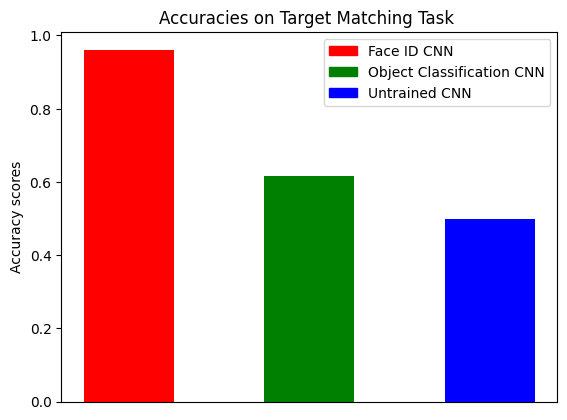

In [38]:
# Define the names and scores of the variables
names = ['Face ID CNN', 'Object Classification CNN', 'Untrained CNN']
scores = [FACE_ID_CNN_Accuracy1, obj_classification_Accuracy1, untrained_Accuracy1]

# Define the color and width of the bars
bar_color = ['red', 'green', 'blue']
bar_width = 0.5

# Create a bar chart with the modified color and width
plt.bar(names, scores, color=bar_color, width=bar_width)

# Remove x-axis labels
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Create a legend mapping color to variable name
legend_elements = [plt.Rectangle((0, 0), 1, 1, color=color) for color in bar_color]
plt.legend(legend_elements, names, loc='upper right')

# Add axis labels and title
plt.ylabel('Accuracy scores')
plt.title('Accuracies on Target Matching Task ')

# Display the chart
plt.show()


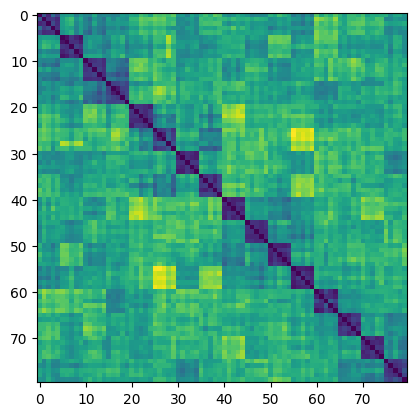

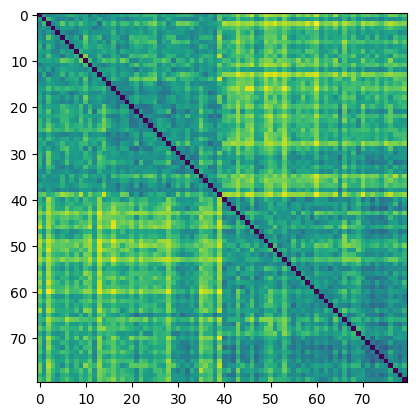

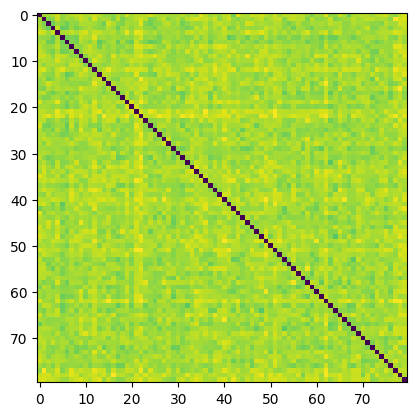

In [68]:
#TASK 2, Alignment Task (Measuring Representational Similarity using RSA)
#The RDMs generated for the pairwise distances between penultimate layer activations of all stimuli are to be compared to that of Human Beings.
#Can't be compared as the Human RDMs were not provided to us by the authors.

def task2(model):
    image_folder = './Task_2/'
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]
    images = []
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    if model == FACE_ID_CNN:
        model.last_linear.register_forward_hook(get_activation('classifier'))
    else:
        model.classifier[4].register_forward_hook(get_activation('classifier'))
    for image_path in image_paths:
        img = Image.open(image_path)
        # Preprocess images
        img = img.convert('RGB')
        image = preprocess(img)
        # Add batch dimension
        img_tensor = image.unsqueeze(0)
        # Get penultimate layer activations
        output = model(img_tensor)
        #CHANGE CODE HERE
        penultimate_layer_activation = activations['classifier'][0].numpy()
        images.append(penultimate_layer_activation)


        

    #Generating RDMs for the model
    RDM = squareform(pdist(images, metric='correlation'))
    plt.imshow(RDM)
    plt.show()
    # Calculate Spearman rank correlation between network RDM and human behavioral RDM
    # spearman_corr, _ = spearmanr(rdm, human_rdm) ##not availiable-> human_rdm
    # return spearman_corr


task2(FACE_ID_CNN)
task2(OBJ_CLASSIFICATION)
task2(UNTRAINED)
# task2(OBJ_FACE_CNN)


#These RDMS are to be compared to the Human RDMs, and Spearman Rank correlation is to be used to compare each of the 
#RDMs generated by the models to the Human RDMs.

In [ ]:
# Task 3, Similarity Matching
# Human beings were tasked to select the face identical to target face out of the two given face images.
# The performance of the CNNs was then compared with that of these CNNs. Since the dataset used for this task has not been provided, 
# this task cannot be replicated for the time being.

In [36]:
# Task 4, Verifying Other Race Effect and Face Inversion Effect

# Human beings performed worse when they were asked to identify the target image, given two images if the faces were inverted, or 
# belonged to different ethinicities the participants were not familiar with.

# Testing Face Inversion Effect:

t4i_start=0
t4i_end=200
t4i_path = './Task_4_inversion/'

FACE_ID_CNN_Accuracy4i = target_matching_resnet(FACE_ID_CNN,t4i_path,t4i_start,t4i_end)
untrained_Accuracy4i = target_matching_vgg16(UNTRAINED,t4i_path,t4i_start,t4i_end)
obj_classification_Accuracy4i = target_matching_vgg16(OBJ_CLASSIFICATION,t4i_path,t4i_start,t4i_end)
# OBJ_FACE_CNN_Accuracy4i = target_matching_vgg16(OBJ_FACE_CNN,t4i_path,t4i_start,t4i_end)


In [59]:
#print the above variables here
print("FACE_ID_CNN_Accuracy4i: ", FACE_ID_CNN_Accuracy4i)
print("untrained_Accuracy4i: ", untrained_Accuracy4i)
print("obj_classification_Accuracy4i: ", obj_classification_Accuracy4i)
# print("obj_fac_cat_Accuracy4i: ", OBJ_FACE_CNN_Accuracy4ii)


FACE_ID_CNN_Accuracy4i:  0.6993589743589743
untrained_Accuracy4i:  0.5147435897435897
obj_classification_Accuracy4i:  0.6352564102564102


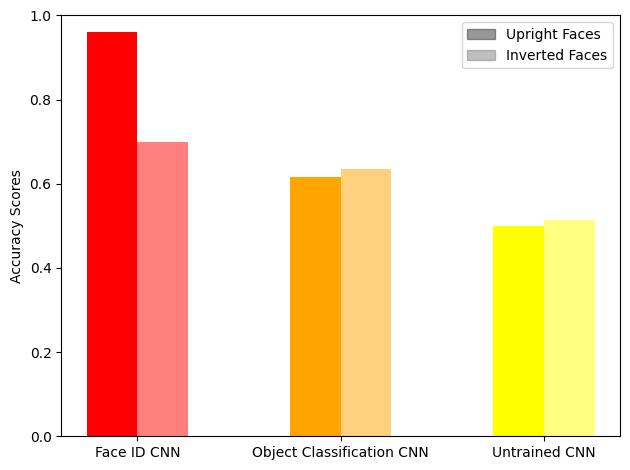

In [56]:
import numpy as np
import matplotlib.pyplot as plt
 
# Define the names and scores of the variables
names = ['Face ID CNN', 'Object Classification CNN', 'Untrained CNN']
scores1 = [FACE_ID_CNN_Accuracy1, obj_classification_Accuracy1, untrained_Accuracy1]
scores2 = [FACE_ID_CNN_Accuracy4i, obj_classification_Accuracy4i, untrained_Accuracy4i]

# Define the color and width of the bars
bar_color = ['red', 'orange', 'yellow']
bar_width = 0.25
legend_color = [(0.2, 0.2, 0.2, 1.0), (0.5, 0.5, 0.5, 1.0) ] 

# Create a figure with a single subplot
fig, ax = plt.subplots()

# Create the first set of bars for each label
ax.bar(np.arange(len(names))-bar_width/2, scores1, width=bar_width, color=bar_color)

# Create the second set of bars for each label
ax.bar(np.arange(len(names))+bar_width/2, scores2, width=bar_width, color=bar_color, alpha=0.5)

# Set the x-ticks to the label names
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)

# Set the y-axis label and limits
ax.set_ylabel('Accuracy Scores')
ax.set_ylim([0,1])

# Add a legend mapping alpha values to variable names
legend_elements = [plt.Rectangle((0, 0), 1, 1, alpha=0.5, color=color) for color in legend_color]
ax.legend(legend_elements, ['Upright Faces', 'Inverted Faces'], loc='upper right')

# Adjust the layout to prevent clipping of x-axis labels
plt.tight_layout()

# Display the chart
plt.show()


In [63]:
# Testing Other Race Effect:
# We take CNNs trained only on white faces, and compare this with the performance on target matching as Task 1 with Asian Faces and White faces.
# We then take a CNN based on the same architecture, but trained on Asian faces, and compare this with the performance on target matching as Task 1 with Asian Faces and White faces.
# The performance drops can be compared with that observed in white and asian participants who underwent this task. 



t4a_start=0
t4a_end=159
t4a_path = './Task_4_other_race/Asian/'
t4w_start=0
t4w_end=199
t4w_path=  './Task_4_other_race/White/'


FACE_ID_CNN_Accuracy4a = target_matching_resnet(FACE_ID_CNN,t4a_path,t4a_start,t4a_end)
untrained_Accuracy4a = target_matching_vgg16(UNTRAINED,t4a_path,t4a_start,t4a_end)
obj_classification_Accuracy4a = target_matching_vgg16(OBJ_CLASSIFICATION,t4a_path,t4a_start,t4a_end)
# FACE_ID_ASIAN_CNN_Accuracy4a = target_matching_vgg16(FACE_ID_ASIAN_CNN,t4a_path,t4a_start,t4a_end)
# FACE_ID_WHITE_CNN_Accuracy4a = target_matching_vgg16(FACE_ID_WHITE_CNN,t4a_path,t4a_start,t4a_end)
FACE_ID_CNN_Accuracy4w = target_matching_resnet(FACE_ID_CNN,t4w_path,t4w_start,t4w_end)
untrained_Accuracy4w = target_matching_vgg16(UNTRAINED,t4w_path,t4w_start,t4w_end)
obj_classification_Accuracy4w = target_matching_vgg16(OBJ_CLASSIFICATION,t4w_path,t4w_start,t4w_end)
# FACE_ID_ASIAN_CNN_Accuracy4w = target_matching_vgg16(FACE_ID_ASIAN_CNN,t4w_path,t4w_start,t4w_end)
# FACE_ID_WHITE_CNN_Accuracy4w = target_matching_vgg16(FACE_ID_WHITE_CNN,t4w_path,t4w_start,t4w_end)


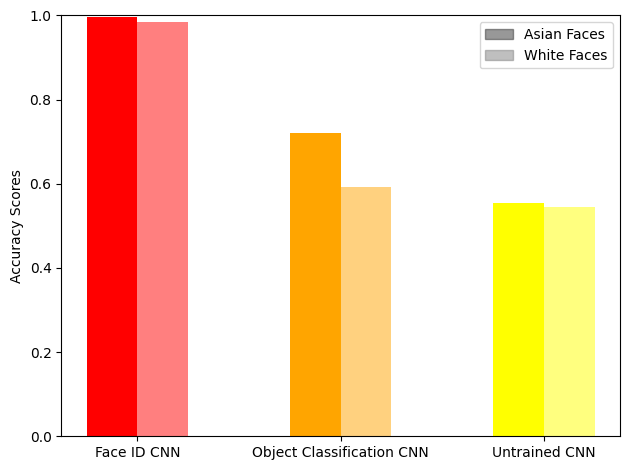

In [64]:
# Define the names and scores of the variables
names = ['Face ID CNN', 'Object Classification CNN', 'Untrained CNN']
scores1 = [FACE_ID_CNN_Accuracy4a, obj_classification_Accuracy4a, untrained_Accuracy4a]
scores2 = [FACE_ID_CNN_Accuracy4w, obj_classification_Accuracy4w, untrained_Accuracy4w]

# Define the color and width of the bars
bar_color = ['red', 'orange', 'yellow']
bar_width = 0.25
legend_color = [(0.2, 0.2, 0.2, 1.0), (0.5, 0.5, 0.5, 1.0) ] 

# Create a figure with a single subplot
fig, ax = plt.subplots()

# Create the first set of bars for each label
ax.bar(np.arange(len(names))-bar_width/2, scores1, width=bar_width, color=bar_color)

# Create the second set of bars for each label
ax.bar(np.arange(len(names))+bar_width/2, scores2, width=bar_width, color=bar_color, alpha=0.5)

# Set the x-ticks to the label names
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)

# Set the y-axis label and limits
ax.set_ylabel('Accuracy Scores')
ax.set_ylim([0,1])

# Add a legend mapping alpha values to variable names
legend_elements = [plt.Rectangle((0, 0), 1, 1, alpha=0.5, color=color) for color in legend_color]
ax.legend(legend_elements, ['Asian Faces', 'White Faces'], loc='upper right')

# Adjust the layout to prevent clipping of x-axis labels
plt.tight_layout()

# Display the chart
plt.show()

In [71]:
# Task 5, Inverted Inversion Effect
# We wish to find out if the drop in performance in inverted faces is 'special' in any sort of way, or is ir just a result of optimisation of 
# our perceptual system. 
# We check the perforance of the Face ID CNN on upright and inverted images and compare how it fares when a CNN trained on inverted faces is
# tested on upright faces as well as inverted faces.

# We also check if such a drop in performance occurs in a CNN specialised in recognising a particular object (We take the example of cars in this case)
# we see if the performance drop occurs when inverted images of cars are presented to these CNNs. This will show that there is nothing 'special' in the face stimuli,
# but the effects such as face inversion effects are a result of optimisation. 

#Inverted Face Inversion Effect

#for this, we use a CNN trained on inverted faces and one on upright faces(one we trained ourself, not the pretrained one we've been using so far),
#in order to compare and contrast the fall in accuracies when the same CNN is trained on inverted faces and tested on upright faces and vice versa. 
t5u_path= './Task_1/'
t5u_start=0
t5u_end=199
t5i_path= './Task_4_inversion/'
t5i_start=0
t5i_end=199

FACE_ID_INVERTED_CNN_Accuracy5u = target_matching_vgg16(FACE_ID_INVERTED_CNN,t5u_path,t5u_start,t5u_end)
FACE_ID_CNN_2_Accuracy5u = target_matching_vgg16(FACE_ID_CNN_2,t5u_path,t5u_start,t5u_end)
FACE_ID_INVERTED_CNN_Accuracy5i = target_matching_vgg16(FACE_ID_INVERTED_CNN,t5i_path,t5i_start,t5i_end)
FACE_ID_CNN_2_Accuracy5i = target_matching_vgg16(FACE_ID_CNN_2,t5i_path,t5i_start,t5i_end)

In [72]:
#print the above results
print('FACE_ID_INVERTED_CNN_Accuracy5u', FACE_ID_CNN_2_Accuracy5u)
print('FACE_ID_CNN_2_Accuracy5u', FACE_ID_CNN_2_Accuracy5u)
print('FACE_ID_INVERTED_CNN_Accuracy5i', FACE_ID_INVERTED_CNN_Accuracy5i)
print('FACE_ID_CNN_2_Accuracy5i', FACE_ID_CNN_2_Accuracy5i)


FACE_ID_INVERTED_CNN_Accuracy5u 0.7211538461538461
FACE_ID_CNN_2_Accuracy5u 0.7211538461538461
FACE_ID_INVERTED_CNN_Accuracy5i 0.6032051282051282
FACE_ID_CNN_2_Accuracy5i 0.7038461538461539


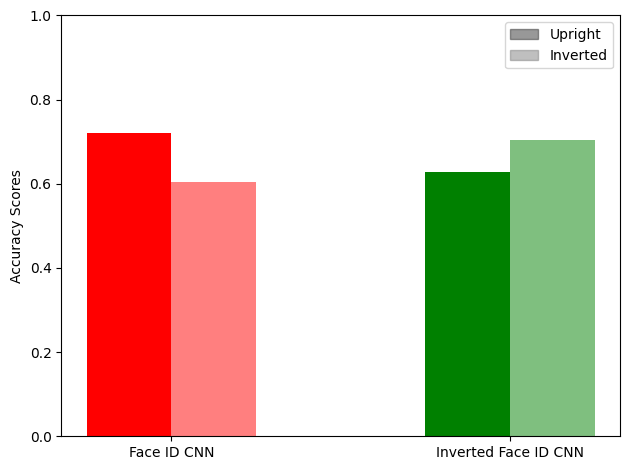

In [74]:
# Define the names and scores of the variables
names = ['Face ID CNN', 'Inverted Face ID CNN']
scores1 = [FACE_ID_CNN_2_Accuracy5u, FACE_ID_INVERTED_CNN_Accuracy5u]
scores2 = [FACE_ID_INVERTED_CNN_Accuracy5i, FACE_ID_CNN_2_Accuracy5i]

# Define the color and width of the bars
bar_color = ['red', 'green']
bar_width = 0.25
legend_color = [(0.2, 0.2, 0.2, 1.0), (0.5, 0.5, 0.5, 1.0) ] 

# Create a figure with a single subplot
fig, ax = plt.subplots()

# Create the first set of bars for each label
ax.bar(np.arange(len(names))-bar_width/2, scores1, width=bar_width, color=bar_color)

# Create the second set of bars for each label
ax.bar(np.arange(len(names))+bar_width/2, scores2, width=bar_width, color=bar_color, alpha=0.5)

# Set the x-ticks to the label names
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)

# Set the y-axis label and limits
ax.set_ylabel('Accuracy Scores')
ax.set_ylim([0,1])

# Add a legend mapping alpha values to variable names
legend_elements = [plt.Rectangle((0, 0), 1, 1, alpha=0.5, color=color) for color in legend_color]
ax.legend(legend_elements, ['Upright', 'Inverted'], loc='upper right')

# Adjust the layout to prevent clipping of x-axis labels
plt.tight_layout()

# Display the chart
plt.show()